## author: Keer Mei
- github: kmei92
- email: keer.mei18@imperial.ac.uk

# Setup

In [1]:
import sys
sys.path.append("..")
from PDESystem import *
from PDESubsystem import *
from pdeforms import *

%load_ext autoreload
%autoreload 2

In [2]:
class pde_solver(PDESystem):
    def __init__(self, comp, mesh, parameters):
        PDESystem.__init__(self, comp, mesh, parameters)

    def setup_bcs(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        c0 = fd.exp(x*y*self.t)
        
        bcu = [fd.DirichletBC(self.V['u'], fd.Constant((0,0)), (10, 12)), # top-bottom 
          fd.DirichletBC(self.V['u'], ((1.0*(y - 1)*(2 - y))/(0.5**2) ,0), 9)] # inflow
        bcp = [fd.DirichletBC(self.V['p'], fd.Constant(0), 11)]  # outflow
        bcc1 = [fd.DirichletBC(self.V['cd'].sub(0), c0, 'on_boundary')]

        self.bc['u'][0] = [bcu, None, None, None,'fixed']
        self.bc['p'] = [[bcp, None, None, None, 'fixed']]
        self.bc['cd'][0] = [bcc1, c0, 'on_boundary', 0, 'update']

    def setup_constants(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        
        self.constants = {
            'k' : fd.Constant(self.prm['dt']),
            'Kd' : fd.Constant(0.01),
            'k1' : fd.Constant(0.5),
            'k2' : fd.Constant(0.01),
            'lamd1' : fd.Constant(1.5),
            'lamd2' : fd.Constant(0.),
            'rho_s' : fd.Constant(1.),
            'L' :  fd.Constant(1.),
            'phi' : fd.Constant(0.3),
            'n' : fd.FacetNormal(self.mesh),
            'f' : fd.Constant((0.0, 0.0)),
            'nu' : fd.Constant(0.001),
            'frac' : fd.Constant(1.)
        }

# MMS Code Verification

## Spatial discretization

In [31]:
import numpy.linalg as nl

solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'cs': fd.MixedFunctionSpace, 'cd' : fd.MixedFunctionSpace, 'as' : fd.MixedFunctionSpace},
'degree': {'u': 2, 'p': 1, 'cs': 1, 'cd' : 1, 'as' : 1},
'order' : {'u': 1, 'p': 1, 'cs' : 2, 'cd' : 2, 'as' : 2, 'cdcsas' : 2},
'linear_solver': {'u': 'gmres', 'p': 'gmres', 'cs': 'gmres', 'cd': 'gmres', 'as': 'gmres'},
'subsystem_class' : {'up': navier_stokes, 'cdcsas' : radio_transport_mms},
'precond': {'u': 'sor', 'p' : 'sor', 'cs': 'sor', 'cd': 'sor', 'as': 'sor'},
'dt' : 0.001,
'T': 2.0
}
)

error_fd_norm = []
dx_array = []

for i in range(1, 4):
    print(i)
    mesh = fd.Mesh("../../meshes/step%d.msh" % i)
    x, y = fd.SpatialCoordinate(mesh)
    # setup a function space to obtain the cell volumes
    DG0 = fd.FunctionSpace(mesh, 'DG', 0)
    b = fd.Function(DG0).interpolate(fd.CellVolume(mesh))
    mean = b.dat.data.mean()
    
    # add subsystems
    solver = pde_solver([['u', 'p']], mesh, solver_parameters)
    solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)
    #setup system and define subsystems
    solver.setup_constants()
    solver.define(['u', 'p', 'u'], 'up', navier_stokes)
    solver.define(['cd', 'cs', 'as'], 'cdcsas', radio_transport_mms)
    solver.setup_bcs()

    #setup initial condition
    x, y = fd.SpatialCoordinate(mesh)
    c = fd.exp(x*y*solver.t)
    solver.setup_initial('cd_n', c, mixedspace=True, index=0)

    #solve
    solver.solve(time_update=True)
    cd1, cd2 = solver.form_args['cd_n'].split()
    c_exact = fd.interpolate(fd.exp(x*y*fd.Constant(solver.prm['T'])), solver.V['cd'][0])
    
    # track error
    error_fd_norm.append(fd.errornorm(c_exact, cd1))
    dx_array.append((np.sqrt(2*mean)))
    


1
time = 1.000
time = 2.000
2
time = 1.000
time = 2.000
3
time = 1.000
time = 2.000


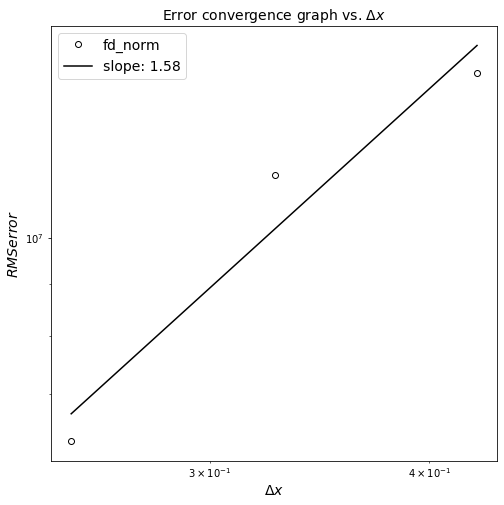

In [33]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
# plot error map

ax1.loglog(dx_array, error_fd_norm, 'o', label='fd_norm', color='k', markerfacecolor='None')
ax1.set_xlabel('$\Delta x$', fontsize=14)
ax1.set_ylabel('$RMS error$', fontsize=14)
ax1.set_title('Error convergence graph vs. $\Delta x$', fontsize=14)
ax1.legend(loc='best', fontsize=14)

# line fit
start_fit = 0
line_fit_uniform_fd = np.polyfit(np.log(dx_array[start_fit:]), np.log(error_fd_norm[start_fit:]), 1)

ax1.loglog(dx_array, np.exp(line_fit_uniform_fd[1]) * dx_array**(line_fit_uniform_fd[0]), 'k-', label = 'slope: {:.2f}'.format(line_fit_uniform_fd[0]))
ax1.legend(loc='best', fontsize=14)


In [ ]:
import sympy as sy

solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'cs': fd.MixedFunctionSpace, 'cd' : fd.MixedFunctionSpace, 'as' : fd.MixedFunctionSpace},
'degree': {'u': 2, 'p': 1, 'cs': 1, 'cd' : 1, 'as' : 1},
'order' : {'u': 1, 'p': 1, 'cs' : 2, 'cd' : 2, 'as' : 2, 'cdcsas' : 2},
'linear_solver': {'u': 'gmres', 'p': 'gmres', 'cs': 'gmres', 'cd': 'gmres', 'as': 'gmres'},
'subsystem_class' : {'up': navier_stokes, 'cdcsas' : radio_transport_mms},
'precond': {'u': 'sor', 'p' : 'sor', 'cs': 'sor', 'cd': 'sor', 'as': 'sor'},
'dt' : 0.001,
'T': 2.0
}
)

meshes = fd.Mesh("../../meshes/step1.msh")

meshes = [fd.Mesh("../../meshes/step%d.msh" % i) for i in range(1, 4)]

# create solver and add systems
solver = pde_solver([['u', 'p']], mesh, solver_parameters)
solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)
#setup system and define subsystems
solver.setup_constants()
solver.define(['u', 'p', 'u'], 'up')
solver.define(['cd', 'cs', 'as'], 'cdcsas')
solver.setup_bcs()

x, y, t = sy.symbols(('x', 'y', 't'))
expr = sy.exp(x*y*t)
solver.test_mms('cd', expr, spatial=True, f_dict={"exp":fd.exp}, meshes=meshes, plot=True, index=0)


yes


SystemError: <built-in method insert of list object at 0x7f34178ee948> returned a result with an error set

Exception ignored in: 'petsc4py.PETSc.traceback'
SystemError: <built-in method insert of list object at 0x7f34178ee948> returned a result with an error set


## Temporal discretization

In [199]:
import sympy as sy

solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'cs': fd.MixedFunctionSpace, 'cd' : fd.MixedFunctionSpace, 'as' : fd.MixedFunctionSpace},
'degree': {'u': 2, 'p': 1, 'cs': 1, 'cd' : 1, 'as' : 1},
'order' : {'u': 1, 'p': 1, 'cs' : 2, 'cd' : 2, 'as' : 2, 'cdcsas' : 2},
'linear_solver': {'u': 'gmres', 'p': 'gmres', 'cs': 'gmres', 'cd': 'gmres', 'as': 'gmres'},
'subsystem_class' : {'up': navier_stokes, 'cdcsas' : radio_transport_mms},
'precond': {'u': 'sor', 'p' : 'sor', 'cs': 'sor', 'cd': 'sor', 'as': 'sor'},
'dt' : 0.01,
'T': 0.1
}
)

mesh = fd.Mesh("../../meshes/step1.msh")
x, y = fd.SpatialCoordinate(mesh)

deltat = [0.01 / (2**i) for i in range(3)]
print(deltat)

# create solver and add systems
solver = pde_solver([['u', 'p']], mesh, solver_parameters)
solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)
#setup system and define subsystems
solver.setup_constants()
solver.define(['u', 'p', 'u'], 'up')
solver.define(['cd', 'cs', 'as'], 'cdcsas')
solver.setup_bcs()

x, y, t = sy.symbols(('x', 'y', 't'))
expr = sy.exp(x*y*t)
solver.test_mms('cd', expr, temporal=True, f_dict={"exp":fd.exp}, dt_list=deltat, plot=True, index=0)


[0.01, 0.005, 0.0025]


UFL:ERROR Replacement expressions must have the same shape as what they replace.


ValueError: Provided residual is not a linear form

In [203]:
deltat = 0.01


solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'cs': fd.MixedFunctionSpace, 'cd' : fd.MixedFunctionSpace, 'as' : fd.MixedFunctionSpace},
'degree': {'u': 2, 'p': 1, 'cs': 1, 'cd' : 1, 'as' : 1},
'order' : {'u': 1, 'p': 1, 'cs' : 2, 'cd' : 2, 'as' : 2, 'cdcsas' : 2},
'linear_solver': {'u': 'gmres', 'p': 'gmres', 'cs': 'gmres', 'cd': 'gmres', 'as': 'gmres'},
'subsystem_class' : {'up': navier_stokes, 'cdcsas' : radio_transport_mms},
'precond': {'u': 'sor', 'p' : 'sor', 'cs': 'sor', 'cd': 'sor', 'as': 'sor'},
'dt' : deltat,
'T': 0.1
}
)

mesh = fd.Mesh("../../meshes/step1.msh")
x, y = fd.SpatialCoordinate(mesh)


error_fd_norm = []
dt_array = []

for i in range(3):
    print(deltat)
    solver_parameters = recursive_update(solver_parameters, {'dt': deltat})
    # create solver and add systems
    solver = pde_solver([['u', 'p']], mesh, solver_parameters)
    solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)
    #setup system and define subsystems
    solver.setup_constants()
    solver.define(['u', 'p', 'u'], 'up')
    solver.define(['cd', 'cs', 'as'], 'cdcsas')
    solver.setup_bcs()
    print(solver.bc)
    print(solver.V['cd'])
    c = fd.exp(x*y*solver.t)
    solver.setup_initial('cd_n', c, mixedspace=True, index=0)
    
    #solve
    solver.solve(time_update=True)
    cd1, cd2 = solver.form_args['cd_n'].split()
    
    # exact solution
    c_exact = fd.interpolate(fd.exp(x*y*fd.Constant(solver.prm['T'])), solver.V['cd'][0])
    # track error
    error_fd_norm.append(fd.errornorm(c_exact, cd1))
    
    # divide time step by 2
    deltat /= 2 
    dt_array.append(deltat)
    
    fd.plot(cd1)
    fd.plot(c_exact)

0.01


AttributeError: 'navier_stokes' object has no attribute 'form0'

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
# plot error map

ax1.loglog(dt_array, error_fd_norm, 'o', label='fd_norm', color='k', markerfacecolor='None')

ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('$RMS error$', fontsize=14)
ax1.set_title('Error convergence graph vs. $\Delta t$', fontsize=14)
ax1.legend(loc='best', fontsize=14)

# line fit
start_fit = 1
line_fit_uniform_fd = np.polyfit(np.log(dt_array[start_fit:]), np.log(error_fd_norm[start_fit:]), 1)

ax1.loglog(dt_array, np.exp(line_fit_uniform_fd[1]) * dt_array**(line_fit_uniform_fd[0]), 'k-', label = 'slope: {:.2f}'.format(line_fit_uniform_fd[0]))
ax1.legend(loc='best', fontsize=14)

In [ ]:
import sympy as sy

x,y,t = sy.symbols(('x', 'y', 't'))
expr = sy.exp(x*y*t)
print(list(expr.free_symbols))
asdf = list(map(str, list(expr.free_symbols)))
asdf.sort()
print(asdf)
# for i in expr.free_symbols:
#     print(str(i))

f = sy.lambdify(list(expr.free_symbols), expr, {"exp" : fd.exp})

# def convert_fd(func, leng=2):
#     mesh = fd.UnitSquareMesh(1, 1)
#     coordinate = fd.SpatialCoordinate(mesh)
#     x, y = coordinate
    
#     return func(x, y)

# convert_fd(f)

mesh = fd.UnitSquareMesh(1, 1)
coordinate = fd.SpatialCoordinate(mesh)
for i in coordinate:
    print(i)

time = fd.Constant(0)
coordinate = list(coordinate)
coordinate.insert(0, time)
arg = dict(zip(asdf, coordinate))
print(arg)
# f(**arg)

# fd.plot(mesh)
# V = fd.FunctionSpace(mesh, 'CG', 1)
# q = fd.Function(V).interpolate(f(**arg))
# fd.plot(q)

# def function(a, b, **kwargs):
#     if kwargs['c']:
#         return a + b + kwargs['c']
#     else:
#         return a + b

# print(function(1, 2))

In [181]:
h = []

abc = [[], 1, 2, 3]

print(abc)
abc[0] = [123]
print(abc)
print(h)

for i in range(6):
    h.append([i])
    h[i].extend([])
    
print(h)

[[], 1, 2, 3]
[[123], 1, 2, 3]
[]
[[0], [1], [2], [3], [4], [5]]
